<a href="https://colab.research.google.com/github/chdb-io/chdb/blob/main/examples/chDB_demos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pandas pyarrow --upgrade >/dev/null 2>&1
!pip install chdb --upgrade >/dev/null 2>&1
!pip show chdb

Name: chdb
Version: 0.14.1
Summary: chDB is an in-process SQL OLAP Engine powered by ClickHouse
Home-page: https://github.com/auxten/chdb
Author: auxten
Author-email: auxtenwpc@gmail.com
License: Apache-2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: 
Required-by: 


GitHub: https://github.com/chdb-io/chdb

# Query on S3/HTTP/File/Another ClickHouse

   RegionID  sum(AdvEngineID)       c  avg(ResolutionWidth)  uniqExact(UserID)
0       229             38044  426435           1612.787187              27961
1         2             12801  148193           1593.870891              10413
2       208              2673   30614           1490.615111               3073
3         1              1802   28577           1623.851699               1720
4        34               508   14329           1592.897201               1428
5        47              1041   13661           1637.851914                943
6       158                78   13294           1576.340605               1110
7         7              1166   11679           1627.319034                647
8        42               642   11547           1625.601022                956
9       184                30   10157           1614.693807                987


<Axes: >

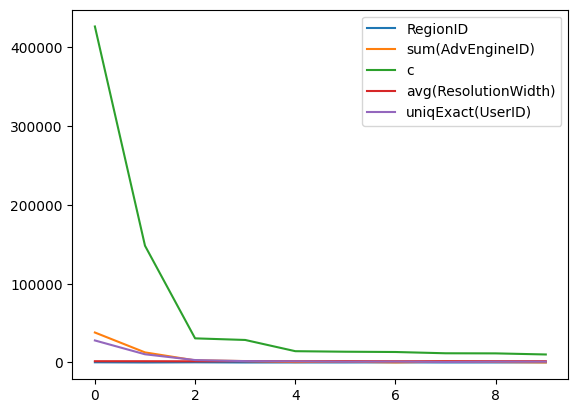

In [2]:

# Run chDB on HTTP (Parquet, CSV, JSON ...)
!wget 'https://datasets.clickhouse.com/hits_compatible/athena_partitioned/hits_0.parquet' -q -O hits_0.parquet
import chdb

data = "url('https://datasets.clickhouse.com/hits_compatible/athena_partitioned/hits_0.parquet')"
# data = "file('hits_0.parquet', Parquet)"
# data = "s3('xxx')"

sql = f"""SELECT RegionID, SUM(AdvEngineID), COUNT(*) AS c, AVG(ResolutionWidth), COUNT(DISTINCT UserID)
                        FROM {data} GROUP BY RegionID ORDER BY c DESC LIMIT 10"""
ret = chdb.query(sql, 'dataframe')
print(ret)
ret.plot()

                                   repo  stars
0                       OpenBMB/ChatDev   1127
1         KillianLucas/open-interpreter    860
2  AUTOMATIC1111/stable-diffusion-webui    635
3                   IceWhaleTech/CasaOS    495
4                    jzhang38/TinyLlama    470
5           zfdang/Android-Touch-Helper    416
6      codecrafters-io/build-your-own-x    410
7                         biomejs/biome    408
8            opentffoundation/manifesto    402
9                      tjy-gitnub/win12    386


<Axes: ylabel='repo'>

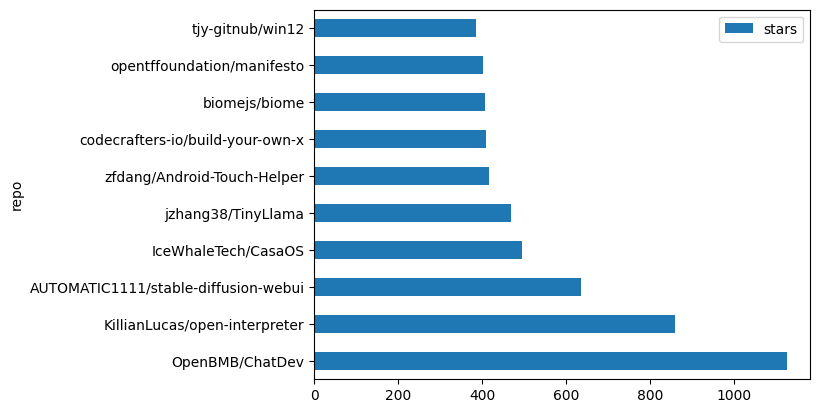

In [3]:
# Query another ClickHouse server
ret = chdb.query("""SELECT
    repo_name AS repo,
    count() AS stars
FROM remoteSecure('play.clickhouse.com', default, github_events, 'play', 'play')
WHERE event_type = 'WatchEvent' AND created_at > today() -1
GROUP BY repo_name
ORDER BY stars DESC
LIMIT 10""", "dataframe")
print(ret)
ret.plot(x='repo', kind='barh')

# Query pandas.Dataframe

In [4]:
# Run on pandas.Dataframe and output Dataframe
import chdb.dataframe as cdf
import pandas as pd

tbl = cdf.Table(dataframe=pd.DataFrame({'i':[1,2,3,4],'j':["one", "two", "three", "four"]}))

ret_tbl = tbl.query('SELECT * FROM __table__')

## Query on result table
ret_tbl.query('SELECT i, i*2, j FROM __table__ ORDER BY i desc')

   i  multiply(i, 2)         j
0  4               8   b'four'
1  3               6  b'three'
2  2               4    b'two'
3  1               2    b'one'

# Stateful Query with session

Select from view:

┏━━━┳━━━┓
┃ x ┃ y ┃
┡━━━╇━━━┩
│ a │ 1 │
├───┼───┤
│ b │ 3 │
├───┼───┤
│ c │ 2 │
├───┼───┤
│ d │ 5 │
└───┴───┘



<Axes: >

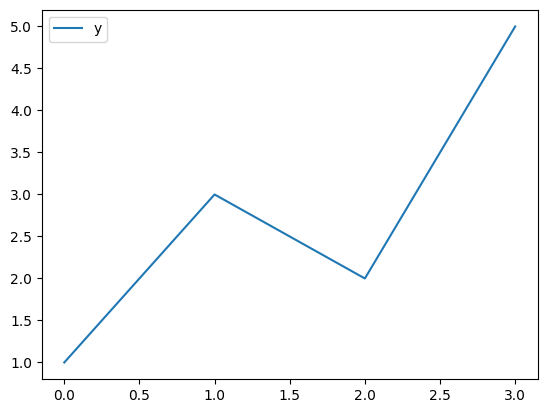

In [5]:
# Run chDB with session

from chdb import session as chs

## Create DB, Table, View in temp session, auto cleanup when session is deleted.
sess = chs.Session()
sess.query("CREATE DATABASE IF NOT EXISTS db_xxx ENGINE = Atomic")
sess.query("CREATE TABLE IF NOT EXISTS db_xxx.log_table_xxx (x String, y Int) ENGINE = Log;")
sess.query("INSERT INTO db_xxx.log_table_xxx VALUES ('a', 1), ('b', 3), ('c', 2), ('d', 5);")
sess.query(
    "CREATE VIEW db_xxx.view_xxx AS SELECT * FROM db_xxx.log_table_xxx LIMIT 4;"
)
print("Select from view:\n")
print(sess.query("SELECT * FROM db_xxx.view_xxx", "Pretty"))

sess.query("SELECT * FROM db_xxx.view_xxx", "dataframe").plot()

In [6]:
## Keep session data in a dir
sess2 = chs.Session("ch_session")
sess2.query("CREATE FUNCTION chdb_version AS () -> '0.11.3'")
print("UDF chdb_version:", sess2.query("SELECT chdb_version()", "CSV"))

print("Content of dir ch_session:")
!ls -l ch_session

## Named session need cleanup,
sess2.cleanup()


UDF chdb_version: "0.11.3"

Content of dir ch_session:
total 28
drwxr-xr-x 3 root root 4096 Sep  5 02:58 data
drwxr-xr-x 4 root root 4096 Sep  5 02:58 metadata
drwxr-xr-x 2 root root 4096 Sep  5 02:58 metadata_dropped
drwxr-xr-x 3 root root 4096 Sep  5 02:58 store
drwxr-xr-x 2 root root 4096 Sep  5 02:58 tmp
drwxr-xr-x 2 root root 4096 Sep  5 02:58 user_defined
drwxr-xr-x 2 root root 4096 Sep  5 02:58 user_scripts


<Axes: xlabel='year'>

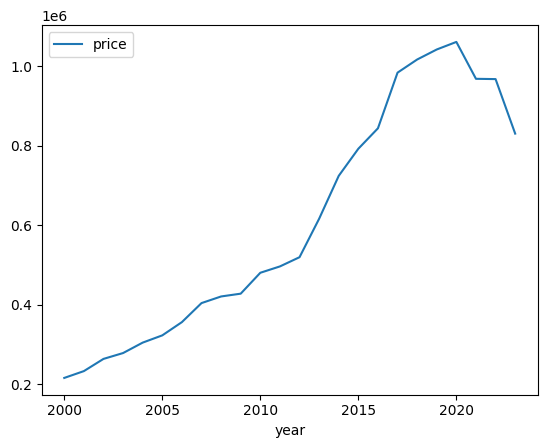

In [7]:
# Plot house price
import chdb

df = chdb.query("SELECT toYear(date::Date32) AS year, round(avg(price)) AS price "
                 "FROM s3('https://datasets-documentation.s3.eu-west-3.amazonaws.com/uk-house-prices/parquet/house_prices_20*.parquet') "
                 "WHERE town = 'LONDON' GROUP BY year ORDER BY year","Dataframe")

df.plot(x='year')

In [8]:
# Query to ArrowTable
import chdb

res = chdb.query(
   f"SELECT town, district, count() AS c, round(avg(price)) AS price "
   f"FROM s3('https://datasets-documentation.s3.eu-west-3.amazonaws.com/uk-house-prices/csv/house_prices.csv.gz') "
   f"GROUP BY town, district HAVING c >= 100 ORDER BY price DESC LIMIT 10",
   "ArrowTable")
print(res)

pyarrow.Table
town: string
district: string
c: uint64 not null
price: double
----
town: [["LONDON","LONDON","LONDON","VIRGINIA WATER","LEATHERHEAD","LONDON","NORTHWOOD","WINDSOR","WINDLESHAM","COBHAM"]]
district: [["CITY OF LONDON","CITY OF WESTMINSTER","KENSINGTON AND CHELSEA","RUNNYMEDE","ELMBRIDGE","CAMDEN","THREE RIVERS","BRACKNELL FOREST","SURREY HEATH","ELMBRIDGE"]]
c: [[729,9605,6549,379,262,7399,150,111,232,925]]
price: [[3212987,2888615,2447372,2115944,2085028,1619476,1493810,1360590,1323741,1307596]]


# chDB v0.13

## Join 2 DataFrames

In [9]:
import chdb.dataframe as cdf
import pandas as pd
# Join 2 DataFrames
print("\n# Join 2 DataFrames:")
df1 = pd.DataFrame({'a': [1, 2, 3], 'b': ["one", "two", "three"]})
df2 = pd.DataFrame({'c': [1, 2, 3], 'd': ["ONE", "TWO", "THREE"]})
ret_tbl = cdf.query(sql="select * from __tbl1__ t1 join __tbl2__ t2 on t1.a = t2.c",
                  tbl1=df1, tbl2=df2)
print(ret_tbl)

# Query on the DataFrame Table
print("\n# Query on the DataFrame Table:")
print(ret_tbl.query('select b, sum(a) from __table__ group by b'))


# Join 2 DataFrames:
   a         b  c         d
0  1    b'one'  1    b'ONE'
1  2    b'two'  2    b'TWO'
2  3  b'three'  3  b'THREE'

# Query on the DataFrame Table:
          b  sum(a)
0    b'two'       2
1  b'three'       3
2    b'one'       1


## Join DataFrame and Parquet

In [10]:
df1 = pd.DataFrame({'a': [1, 2, 3], 'b': ["one", "two", "three"]})
df2 = pd.DataFrame({'c': [1, 2, 3], 'd': ["ONE", "TWO", "THREE"]})
# Save df2 to Parquet file
df2.to_parquet('df2.parquet')

print("\n# Join DataFrame and Parquet:")
print(cdf.query(sql="select * from __tbl1__ t1 join __tbl2__ t2 on t1.a = t2.c",
                  tbl1=df1, tbl2=cdf.Table(parquet_path='df2.parquet')))


# Join DataFrame and Parquet:
   a         b  c         d
0  1    b'one'  1    b'ONE'
1  2    b'two'  2    b'TWO'
2  3  b'three'  3  b'THREE'


## Query Statistics

In [11]:
# Query read_rows, read_bytes, elapsed time
data = "file('hits_0.parquet', Parquet)"
sql = f"""SELECT RegionID, SUM(AdvEngineID), COUNT(*) AS c, AVG(ResolutionWidth), COUNT(DISTINCT UserID)
                        FROM {data} GROUP BY RegionID ORDER BY c DESC"""
res = chdb.query(sql)
print(f"\nSQL read {res.rows_read()} rows, {res.bytes_read()} bytes, elapsed {res.elapsed()} seconds")


SQL read 1242 rows, 48438 bytes, elapsed 0.083294458 seconds


# chDB v0.14

## Python UDF

In [12]:
from chdb.udf import chdb_udf
from chdb import query

@chdb_udf()
def sum_udf(lhs, rhs):
    return int(lhs) + int(rhs)

print(query("select sum_udf(12,22)"))

"34"



## with Session() as sess

Select from view:

┏━━━┳━━━┓
┃ x ┃ y ┃
┡━━━╇━━━┩
│ a │ 1 │
├───┼───┤
│ b │ 3 │
├───┼───┤
│ c │ 2 │
├───┼───┤
│ d │ 5 │
└───┴───┘



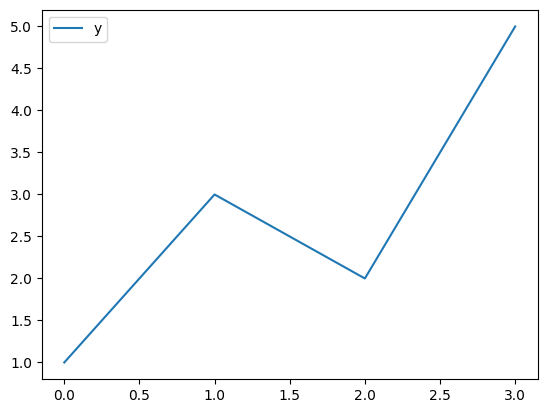

In [13]:
## Create DB, Table, View in temp session, auto cleanup outof `with` block.
with chs.Session() as sess:
  sess.query("CREATE DATABASE IF NOT EXISTS db_xxx ENGINE = Atomic")
  sess.query("CREATE TABLE IF NOT EXISTS db_xxx.log_table_xxx (x String, y Int) ENGINE = Log;")
  sess.query("INSERT INTO db_xxx.log_table_xxx VALUES ('a', 1), ('b', 3), ('c', 2), ('d', 5);")
  sess.query(
      "CREATE VIEW db_xxx.view_xxx AS SELECT * FROM db_xxx.log_table_xxx LIMIT 4;"
  )
  print("Select from view:\n")
  print(sess.query("SELECT * FROM db_xxx.view_xxx", "Pretty"))

  sess.query("SELECT * FROM db_xxx.view_xxx", "dataframe").plot()